In [19]:
import sys
sys.path.insert(0, "../")
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import torch
 
data = pd.read_csv(r"../sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

In [20]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

In [21]:
import torch
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES, LABEL_COLUMN_NAME

data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

X = data[FEATURES].values
y = data[LABEL_COLUMN_NAME].values

In [22]:
id_grouped_data = data.groupby("Id")

In [23]:
num_sampples_list =  []
for i in range(id_grouped_data.size().max()+1):
    num_samples = (id_grouped_data.size() == i).sum()
    num_sampples_list.append(num_samples)

Text(0.5, 0, 'Length of time series')

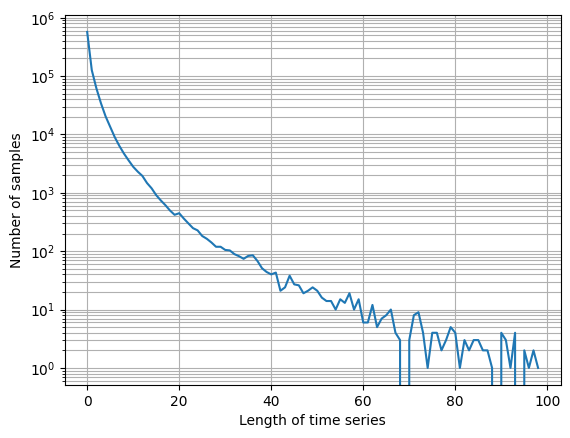

In [24]:
import matplotlib.pyplot as plt
plt.semilogy(num_sampples_list[1:100])
plt.grid(which="both")
plt.ylabel("Number of samples")
plt.xlabel("Length of time series")

In [33]:
from tqdm.notebook import tqdm
seqlen_to_controlnum = dict({})
seqlen_to_sepsisnum = dict({})

for i, data_group in tqdm(id_grouped_data):
    seqlen = data_group.shape[0]
    if seqlen not in seqlen_to_controlnum:
        seqlen_to_controlnum[seqlen] = 0
    if seqlen not in seqlen_to_sepsisnum:
        seqlen_to_sepsisnum[seqlen] = 0
    if 1 in data_group["Label"].tolist():
        seqlen_to_sepsisnum[seqlen] += 1
    if 1 not in data_group["Label"].tolist():
        seqlen_to_controlnum[seqlen] += 1

  0%|          | 0/866517 [00:00<?, ?it/s]

In [34]:
from collections import OrderedDict

sorted_seqlen_to_controlnum = OrderedDict(sorted(seqlen_to_controlnum.items()))
sorted_seqlen_to_sepsisnum = OrderedDict(sorted(seqlen_to_sepsisnum.items()))

In [46]:
seq_lens = []
ratios = []
c_ratios = []
for key in sorted_seqlen_to_controlnum.keys():
    seq_lens.append(key)
    ratios.append(sorted_seqlen_to_sepsisnum[key] / (sorted_seqlen_to_sepsisnum[key] + sorted_seqlen_to_controlnum[key]))
    c_ratios.append(sorted_seqlen_to_controlnum[key] / (sorted_seqlen_to_sepsisnum[key] + sorted_seqlen_to_controlnum[key]))

In [36]:
sum(sorted_seqlen_to_sepsisnum.values())

2398

In [44]:
sorted_seqlen_to_sepsisnum

OrderedDict([(1, 1624),
             (2, 160),
             (3, 117),
             (4, 77),
             (5, 53),
             (6, 51),
             (7, 30),
             (8, 24),
             (9, 21),
             (10, 19),
             (11, 14),
             (12, 9),
             (13, 14),
             (14, 12),
             (15, 13),
             (16, 14),
             (17, 6),
             (18, 7),
             (19, 7),
             (20, 4),
             (21, 7),
             (22, 3),
             (23, 2),
             (24, 9),
             (25, 3),
             (26, 3),
             (27, 1),
             (28, 3),
             (29, 2),
             (30, 3),
             (31, 1),
             (32, 4),
             (33, 0),
             (34, 5),
             (35, 3),
             (36, 3),
             (37, 1),
             (38, 3),
             (39, 2),
             (40, 1),
             (41, 2),
             (42, 2),
             (43, 1),
             (44, 3),
             (45, 2),


In [38]:
sorted_seqlen_to_controlnum

OrderedDict([(1, 568627),
             (2, 126162),
             (3, 61627),
             (4, 34026),
             (5, 20359),
             (6, 13450),
             (7, 8923),
             (8, 6325),
             (9, 4665),
             (10, 3576),
             (11, 2779),
             (12, 2291),
             (13, 1931),
             (14, 1459),
             (15, 1182),
             (16, 898),
             (17, 734),
             (18, 607),
             (19, 490),
             (20, 416),
             (21, 440),
             (22, 359),
             (23, 297),
             (24, 239),
             (25, 224),
             (26, 179),
             (27, 162),
             (28, 138),
             (29, 117),
             (30, 116),
             (31, 104),
             (32, 99),
             (33, 89),
             (34, 77),
             (35, 71),
             (36, 80),
             (37, 84),
             (38, 65),
             (39, 49),
             (40, 43),
             (41, 38),
            

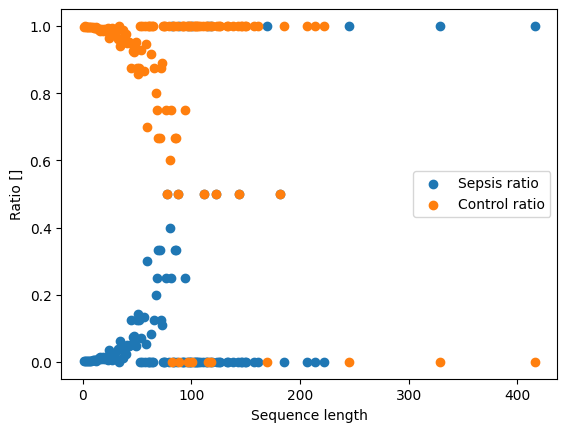

In [47]:
import matplotlib.pyplot as plt

plt.scatter(seq_lens, ratios)
plt.scatter(seq_lens, c_ratios)
plt.ylabel("Ratio []")
plt.xlabel("Sequence length")
plt.legend(["Sepsis ratio", "Control ratio"])

In [54]:
import numpy as np
seq_lens_all = []
for i, data_group in id_grouped_data:
    seq_lens_all.extend(np.repeat(data_group.shape[0], data_group.shape[0]))

In [41]:
data["Label"]

0          0
1          0
2          0
3          0
4          0
          ..
1819430    0
1819431    0
1819432    0
1819433    0
1819434    0
Name: Label, Length: 1819435, dtype: int8

In [55]:
from scipy.stats import pearsonr
pearsonr(data["Label"], seq_lens_all)

PearsonRResult(statistic=-0.003889546589508779, pvalue=1.5502684864056664e-07)

In [57]:
len(seq_lens_all)

1819435